In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_data = pd.read_parquet("../data/unadultered/train_data.parquet")
test_data = pd.read_parquet("../data/unadultered/test_data.parquet").reset_index()

In [3]:
def clean_data(data, debug=True, y_value=True, fillna_method='smart'):
    """
    Cleans the CTR data by converting data types and encoding categorical features.

    Args:
        data (pd.DataFrame): raw train or test data
        debug (bool): if True, prints debugging info
        y_value (bool): whether to process 'y' column
        fillna_method (str): 'zero', 'smart', or 'none'

    Returns:
        pd.DataFrame: cleaned and typed data
    """

    cleaned_data = data.copy()
    
    # Columns: f42, f50, f52–f56 are originally string categorical
    categorical_columns = [42, 50] + list(range(52, 58))  
    
    # OHE columns — expect 0/1, currently string
    ohe_columns = list(range(226, 310))
    
    for col_num in range(1, 367):
        col = f"f{col_num}"
        if debug: print(f"{col}:", end=" ")

        ## A. One-hot encoded columns
        if col_num in ohe_columns:
            cleaned_data[col] = pd.to_numeric(data[col], errors="coerce").fillna(0).astype(int)
            if debug: print("OHE (0/1) int")

        ## B. Categorical columns (originally dropped)
        elif col_num in categorical_columns:
            cleaned_data[col] = cleaned_data[col].astype(str).fillna("unknown")
            le = LabelEncoder()
            try:
                cleaned_data[col] = le.fit_transform(cleaned_data[col])
                if debug: print("categorical → label encoded")
            except:
                if debug: print("categorical → failed to encode")

        ## C. Try parsing as numeric (float or int)
        else:
            col_data = pd.to_numeric(cleaned_data[col], errors="coerce")
            if (col_data.dropna() % 1 != 0).any():
                cleaned_data[col] = col_data.astype(float)
                if debug: print("float")
            else:
                cleaned_data[col] = col_data.astype("Int64")
                if debug: print("Int")

    # Handle target column 'y'
    if y_value and "y" in data.columns:
        cleaned_data["y"] = pd.to_numeric(data["y"], errors="coerce").fillna(0).astype("Int64")

    # Fill missing values
    if fillna_method == 'zero':
        cleaned_data = cleaned_data.fillna(0)
    elif fillna_method == 'smart':
        for col in cleaned_data.columns:
            if pd.api.types.is_numeric_dtype(cleaned_data[col]):
                cleaned_data[col] = cleaned_data[col].fillna(0)
            elif pd.api.types.is_object_dtype(cleaned_data[col]):
                cleaned_data[col] = cleaned_data[col].fillna("unknown")
    # else leave NaNs (for special handling later)

    return cleaned_data


In [4]:
# cleaned Training Data
clean_train_data = clean_data(data=train_data,debug=False,y_value=True)
clean_test_data = clean_data(data=test_data,debug=False,y_value=False)
df = clean_train_data.copy()

In [9]:
extra = pd.DataFrame({})
extra['pages_visited_sum'] = df[[f"f{i}" for i in range(14, 22)]].sum(axis=1)
extra['page_acq_ratio'] = df['f17'] / extra['pages_visited_sum'].replace(0, 1)
extra['time_decay_all_pages'] = df['f59'] / df['f68'].replace(0, 1)

In [8]:
clean_train_data["f68"].value_counts()

f68
0           10021
15433207      431
15264892      373
15365668      362
12770349      362
            ...  
15108115        1
14336237        1
15519579        1
15498205        1
13305071        1
Name: count, Length: 48598, dtype: Int64

In [11]:
#Feature Engineering 

# Number of pages visited
# Note the summing up across column direction
clean_train_data['c2'] = clean_train_data[[f"f{i}" for i in range(14, 22)]].sum(axis=1)
# Drop these columns
clean_train_data.drop([f"f{i}" for i in range(14, 22)],axis=1)

# The degradation of views and time spent on an website
clean_train_data['c3'] = clean_train_data['f59'] / clean_train_data['f68'].replace(0, 1)
# drop these columns
clean_train_data.drop(["f59", 'f68'],axis=1)

C:\Users\rohan\AppData\Local\Temp\ipykernel_30676\2997582461.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clean_train_data['c2'] = clean_train_data[[f"f{i}" for i in range(14, 22)]].sum(axis=1)
C:\Users\rohan\AppData\Local\Temp\ipykernel_30676\2997582461.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clean_train_data['c3'] = clean_train_data['f59'] / clean_train_data['f68'].replace(0, 1)


,id1,id2,id3,id4,id5,y,f1,f2,f3,f4,...,f359,f360,f361,f362,f363,f364,f365,f366,c2,c3
0,1366776_189706075_16-23_2023-11-02 22:22:00.042,1366776,189706075,2023-11-02 22:22:00.042,2023-11-02,0,1,0,0,0,...,0,0,28,0,0.000000,337,0,0.000000,0,0.073458
1,1366776_89227_16-23_2023-11-01 23:51:24.999,1366776,89227,2023-11-01 23:51:24.999,2023-11-01,0,1,0,0,0,...,0,0,87,0,0.000000,1010,2,0.001980,0,0.073458
2,1366776_35046_16-23_2023-11-01 00:30:59.797,1366776,35046,2023-11-01 00:30:59.797,2023-11-01,0,1,0,0,0,...,0,0,23,0,0.000000,1010,2,0.001980,0,0.00007
3,1366776_6275451_16-23_2023-11-02 22:21:32.261,1366776,6275451,2023-11-02 22:21:32.261,2023-11-02,0,1,0,0,0,...,0,0,277,1,0.003610,337,0,0.000000,0,0.073458
4,1366776_78053_16-23_2023-11-02 22:21:34.799,1366776,78053,2023-11-02 22:21:34.799,2023-11-02,0,1,0,0,0,...,0,0,359,0,0.000000,337,0,0.000000,0,0.073458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770159,1896641_87731_16-23_2023-11-02 08:14:21.524,1896641,87731,2023-11-02 08:14:21.524,2023-11-02,0,0,0,0,0,...,0,0,90,1,0.011111,282,1,0.003546,0,0.11927
770160,1896641_505604_16-23_2023-11-02 08:14:24.458,1896641,505604,2023-11-02 08:14:24.458,2023-11-02,0,0,0,0,0,...,0,0,33,0,0.000000,58,1,0.017241,0,0.11927
770161,1896641_25212_16-23_2023-11-02 08:14:25.748,1896641,25212,2023-11-02 08:14:25.748,2023-11-02,0,0,0,0,0,...,0,0,33,0,0.000000,58,1,0.017241,0,0.11927
770162,1900765_95157_16-23_2023-11-02 06:08:25.900,1900765,95157,2023-11-02 06:08:25.900,2023-11-02,0,0,0,0,0,...,0,0,0,0,0.000000,0,0,0.000000,0,0.000003


In [12]:
# Separate out the y and X from each case
# Splitting the data into the Xdata and Ydata
Xdata = clean_train_data.iloc[:,6:]
Ydata = clean_train_data.iloc[:,5]
X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.1)

## Model fitting

In [13]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

base_model = SGDClassifier(loss='log_loss',class_weight="balanced", random_state=42)
model = CalibratedClassifierCV(base_model, method='sigmoid', cv=5)

model.fit(X_train, y_train)

,estimator,SGDClassifier...ndom_state=42)
,method,'sigmoid'
,cv,5
,n_jobs,None
,ensemble,'auto'
,loss,'log_loss'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000


---

## testing out the model

In [14]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("Log Loss:", log_loss(y_test, y_pred_proba))

AUC: 0.7478239044348504
Log Loss: 0.17705294218708287


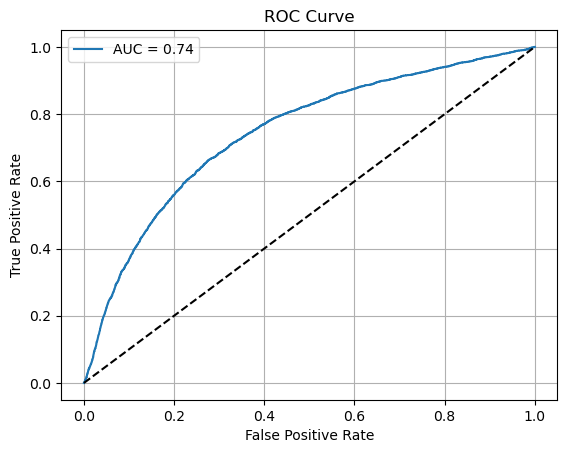

In [43]:
# ROC Curve (Receiver Operating Characteristic)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

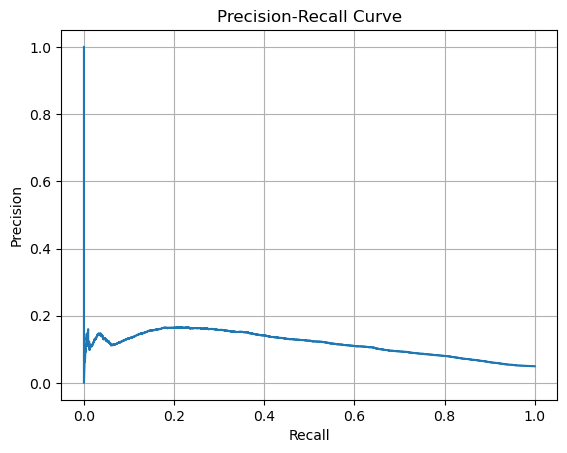

In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

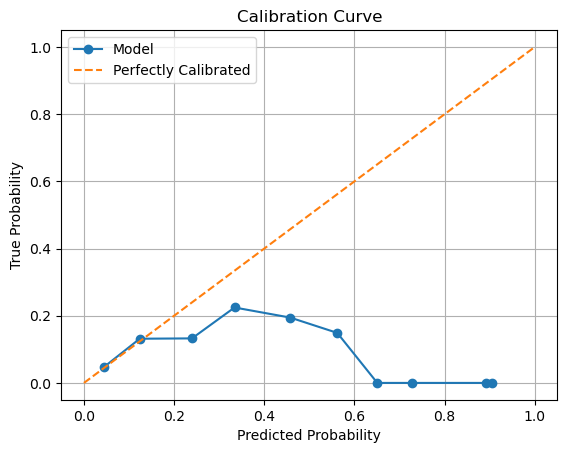

In [34]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

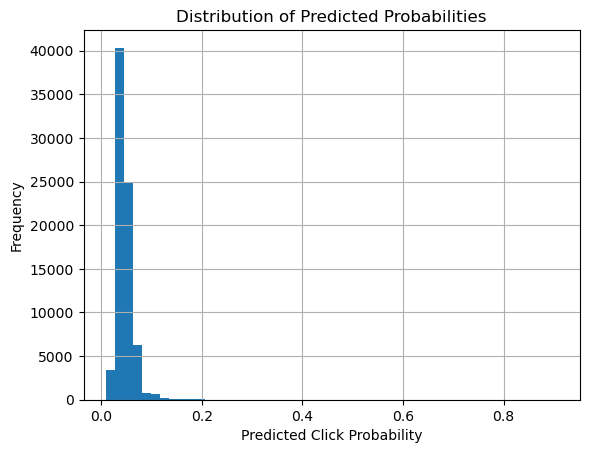

In [35]:
plt.hist(y_pred_proba, bins=50)
plt.xlabel('Predicted Click Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.grid(True)
plt.show()

---
## predicting the new probability values

In [20]:
# Using the cleaned test data to figure out the probabilities of clicks
X_clean_test = clean_test_data.iloc[:,6:].drop("y",axis=1)
y_pred_proba_test = model.predict_proba(X_clean_test)[:, 1]

In [22]:
df_click_probs = pd.DataFrame({"click_probabability": y_pred_proba_test})
df_click_probs.to_csv('click_probabilities_sgdc.csv', index=False)

In [19]:
clean_test_data.head()

,index,id1,id2,id3,id4,id5,f1,f2,f3,f4,...,f358,f359,f360,f361,f362,f363,f364,f365,f366,y
0,46756,1362907_91950_16-23_2023-11-04 18:56:26.000794,1362907,91950,2023-11-04 18:56:26.000794,2023-11-04,0,0,0,0,...,0.046600,True,False,1,0,0.000000,56,0,0.000000,0
1,57819,1082599_88356_16-23_2023-11-04 06:08:53.373,1082599,88356,2023-11-04 06:08:53.373,2023-11-04,0,9,0,0,...,0.060309,True,False,195,13,0.066667,0,0,0.000000,0
2,15390,1888466_958700_16-23_2023-11-05 10:07:28.000725,1888466,958700,2023-11-05 10:07:28.000725,2023-11-05,0,0,0,0,...,0.073484,True,False,155,67,0.432258,1142,436,0.381786,0
3,145730,1888971_795739_16-23_2023-11-04 12:25:28.244,1888971,795739,2023-11-04 12:25:28.244,2023-11-04,0,0,0,0,...,0.040572,True,False,0,0,0.000000,0,0,0.000000,0
4,146085,1256369_82296_16-23_2023-11-05 06:45:26.657,1256369,82296,2023-11-05 06:45:26.657,2023-11-05,0,0,0,0,...,0.038244,True,False,29,2,0.068966,361,3,0.008310,0
